### Pre-Check

In [12]:
import pandas as pd

df = pd.read_csv('../data/data.csv')
print("Columns:", df.columns.tolist())
print("First few rows:")
print(df.head())

Columns: ['url', 'html_content']
First few rows:
                                                 url  \
0     https://www.cm-alliance.com/cybersecurity-blog   
1    https://www.varonis.com/blog/cybersecurity-tips   
2  https://www.cisecurity.org/insights/blog/11-cy...   
3  https://www.cisa.gov/topics/cybersecurity-best...   
4  https://www.qnbtrust.bank/Resources/Learning-C...   

                                        html_content  
0  <!doctype html><!--[if lt IE 7]> <html class="...  
1  <!doctype html><html lang="en"><head>\n    <me...  
2  <!DOCTYPE html><html data-unhead-vue-server-re...  
3  \n\n<!DOCTYPE html>\n<html lang="en" dir="ltr"...  
4                                                NaN  


### HTML Parsing & Data Extraction

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np

def extract_main_content(soup):
    """Extract main body text from HTML"""
    # Try multiple content selectors
    selectors = ['article', 'main', '.content', '.post-content', 'p']
    for selector in selectors:
        elements = soup.select(selector)
        if elements:
            text = ' '.join([elem.get_text().strip() for elem in elements])
            if len(text) > 100:  # Meaningful content
                return text
    
    # Fallback: get all text
    return soup.get_text()

def parse_html_content(html_content):
    """Parse HTML and extract title, body text, word count"""
    if pd.isna(html_content):
        return "", "", 0
    
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        
        # Extract title
        title = soup.title.string if soup.title else ""
        
        # Extract main content
        body_text = extract_main_content(soup)
        
        # Clean text
        body_text = ' '.join(body_text.split())
        word_count = len(body_text.split())
        
        return title, body_text, word_count
    
    except Exception as e:
        print(f"Error parsing HTML: {e}")
        return "", "", 0

# Load the dataset
df = pd.read_csv('../data/data.csv')
print(f"Loaded dataset with {len(df)} rows")

# Parse HTML content
print("Parsing HTML content...")
results = df['html_content'].apply(parse_html_content)
df[['url_title', 'body_text', 'word_count']] = pd.DataFrame(results.tolist(), index=df.index)

# Save extracted content
df[['url', 'url_title', 'body_text', 'word_count']].to_csv('../data/extracted_content.csv', index=False)

print(f"Successfully extracted content from {df['body_text'].str.len().gt(0).sum()} pages")
print("Saved to ../data/extracted_content.csv")

Loaded dataset with 81 rows
Parsing HTML content...
Successfully extracted content from 69 pages
Saved to ../data/extracted_content.csv


### Feature Engineering

In [ ]:
import pandas as pd
import numpy as np
from textstat import flesch_reading_ease
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import Counter

# Load the extracted content
df = pd.read_csv('../data/extracted_content.csv')
print(f"Loaded {len(df)} rows from extracted_content.csv")

def clean_text(text):
    """Clean and preprocess text"""
    if pd.isna(text) or text == "":
        return ""
    
    # Convert to lowercase and remove extra whitespace
    text = ' '.join(str(text).split())
    return text.lower()

def extract_top_keywords(text, n=5):
    """Extract top keywords using TF-IDF approach"""
    if not text or len(text.split()) < 5:
        return []
    
    # Simple word frequency approach
    words = re.findall(r'\b[a-zA-Z]{3,15}\b', text)
    word_freq = Counter(words)
    
    # Remove common stop words
    stop_words = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 
                  'this', 'that', 'with', 'have', 'has', 'had', 'was', 'were',
                  'will', 'would', 'could', 'should', 'from', 'they', 'their'}
    
    keywords = [(word, count) for word, count in word_freq.items() 
                if word not in stop_words and count > 1]
    keywords.sort(key=lambda x: x[1], reverse=True)
    
    return [word for word, count in keywords[:n]]

def calculate_readability(text):
    """Calculate Flesch Reading Ease score"""
    if not text or len(text.split()) < 10:
        return 0
    try:
        return flesch_reading_ease(text)
    except:
        return 0

# Apply text cleaning
df['cleaned_text'] = df['body_text'].apply(clean_text)

# Calculate features
df['sentence_count'] = df['cleaned_text'].apply(lambda x: len(re.findall(r'[.!?]+', x)))
df['flesch_reading_ease'] = df['cleaned_text'].apply(calculate_readability)
df['top_keywords'] = df['cleaned_text'].apply(lambda x: '|'.join(extract_top_keywords(x)))

print("Sample features:")
print(df[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords']].head())

# Save features
features_df = df[['url', 'word_count', 'sentence_count', 'flesch_reading_ease', 'top_keywords']]
features_df.to_csv('../data/features.csv', index=False)
print("Features saved to ../data/features.csv")

Loaded 81 rows from extracted_content.csv
Sample features:
                                                 url  word_count  \
0     https://www.cm-alliance.com/cybersecurity-blog         326   
1    https://www.varonis.com/blog/cybersecurity-tips        1692   
2  https://www.cisecurity.org/insights/blog/11-cy...        1054   
3  https://www.cisa.gov/topics/cybersecurity-best...         825   
4  https://www.qnbtrust.bank/Resources/Learning-C...           0   

   sentence_count  flesch_reading_ease  \
0               7            -6.816181   
1              94            41.465000   
2              72            52.812916   
3              33            -2.620122   
4               0             0.000000   

                              top_keywords  
0    cyber|our|your|cybersecurity|training  
1            your|data|access|can|security  
2               your|can|use|password|data  
3  cybersecurity|cyber|cisa|practices|best  
4                                           
Features 

### Duplicate Detection

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load features
df = pd.read_csv('../data/features.csv')
extracted_df = pd.read_csv('../data/extracted_content.csv')

print(f"Loaded {len(df)} rows for duplicate detection")

# Create TF-IDF vectors for similarity comparison
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(extracted_df['body_text'].fillna(''))

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Computed similarity matrix: {cosine_sim.shape}")

# Find duplicate pairs above threshold
def find_duplicate_pairs(cosine_sim, urls, threshold=0.8):
    duplicates = []
    n = len(urls)
    
    for i in range(n):
        for j in range(i+1, n):
            if cosine_sim[i][j] > threshold:
                duplicates.append({
                    'url1': urls[i],
                    'url2': urls[j], 
                    'similarity': round(cosine_sim[i][j], 3)
                })
    
    return duplicates

# Get duplicate pairs
urls = df['url'].tolist()
duplicate_pairs = find_duplicate_pairs(cosine_sim, urls, threshold=0.8)

# Create thin content flag
df['is_thin'] = df['word_count'] < 500

print(f"\n--- DUPLICATE DETECTION RESULTS ---")
print(f"Total pages analyzed: {len(df)}")
print(f"Duplicate pairs found: {len(duplicate_pairs)}")
print(f"Thin content pages (word_count < 500): {df['is_thin'].sum()} ({df['is_thin'].mean()*100:.1f}%)")

# Save duplicates to CSV
if duplicate_pairs:
    duplicates_df = pd.DataFrame(duplicate_pairs)
    duplicates_df.to_csv('../data/duplicates.csv', index=False)
    print(f"Duplicate pairs saved to data/duplicates.csv")
    print("\nTop duplicate pairs:")
    print(duplicates_df.head())
else:
    print("No duplicates found above threshold")

# Save updated features with thin content flag
df.to_csv('../data/features.csv', index=False)
print("Updated features with thin content flag saved")

Loaded 81 rows for duplicate detection
Computed similarity matrix: (81, 81)

--- DUPLICATE DETECTION RESULTS ---
Total pages analyzed: 81
Duplicate pairs found: 15
Thin content pages (word_count < 500): 35 (43.2%)
Duplicate pairs saved to data/duplicates.csv

Top duplicate pairs:
                                                url1  \
0  https://nordlayer.com/learn/network-security/b...   
1  https://www.fortinet.com/resources/cyberglossa...   
2               https://en.wikipedia.org/wiki/SD-WAN   
3  https://www.microsoft.com/en-us/security/busin...   
4      https://sign.dropbox.com/products/dropbox-fax   

                                                url2  similarity  
0  https://www.fortinet.com/resources/cyberglossa...       0.802  
1  https://www.cisco.com/site/us/en/learn/topics/...       0.846  
2  https://www.cisco.com/site/us/en/learn/topics/...       0.808  
3  https://www.zscaler.com/resources/security-ter...       0.895  
4                              https://www.fax.

### Quality Classification

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
df = pd.read_csv('../data/features.csv')
print(f"Loaded {len(df)} rows for quality scoring")

# Create synthetic quality labels based on assignment rules
def create_quality_labels(row):
    if row['word_count'] > 1500 and 50 <= row['flesch_reading_ease'] <= 70:
        return 'High'
    elif row['word_count'] < 500 or row['flesch_reading_ease'] < 30:
        return 'Low'
    else:
        return 'Medium'

df['quality_label'] = df.apply(create_quality_labels, axis=1)

print("\n--- QUALITY LABEL DISTRIBUTION ---")
print(df['quality_label'].value_counts())

# Prepare features for ML
feature_columns = ['word_count', 'sentence_count', 'flesch_reading_ease']
X = df[feature_columns]
y = df['quality_label']

# Handle any missing values
X = X.fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Random Forest model
print("\n--- TRAINING RANDOM FOREST MODEL ---")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate baseline (rule-based using word count only)
def baseline_predictor(word_count):
    if word_count > 1500:
        return 'High'
    elif word_count < 500:
        return 'Low'
    else:
        return 'Medium'

y_baseline = X_test['word_count'].apply(baseline_predictor)

# Calculate accuracies
model_accuracy = accuracy_score(y_test, y_pred)
baseline_accuracy = accuracy_score(y_test, y_baseline)

print("\n--- MODEL PERFORMANCE ---")
print(f"Model Accuracy: {model_accuracy:.3f}")
print(f"Baseline Accuracy (word count only): {baseline_accuracy:.3f}")
print(f"Improvement: {model_accuracy - baseline_accuracy:.3f}")

# Detailed classification report
print("\n--- DETAILED CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['High', 'Low', 'Medium']))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- FEATURE IMPORTANCE ---")
print(feature_importance)

# Save the model
import joblib
joblib.dump(model, '../models/quality_model.pkl')
print(f"\nModel saved to models/quality_model.pkl")

# Add predictions to dataframe
df['predicted_quality'] = model.predict(X)

# Save updated features with predictions
df.to_csv('../data/features.csv', index=False)
print("Updated features with predictions saved")

Loaded 81 rows for quality scoring

--- QUALITY LABEL DISTRIBUTION ---
quality_label
Low       51
Medium    23
High       7
Name: count, dtype: int64

Training set: 56 samples
Test set: 25 samples

--- TRAINING RANDOM FOREST MODEL ---

--- MODEL PERFORMANCE ---
Model Accuracy: 0.920
Baseline Accuracy (word count only): 0.640
Improvement: 0.280

--- DETAILED CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       0.94      1.00      0.97        16
      Medium       1.00      0.71      0.83         7

    accuracy                           0.92        25
   macro avg       0.87      0.90      0.87        25
weighted avg       0.94      0.92      0.92        25


--- FEATURE IMPORTANCE ---
               feature  importance
2  flesch_reading_ease    0.409970
1       sentence_count    0.299325
0           word_count    0.290704

Model saved to models/quality_model.pkl
Updated features with pr

### Real-time Analysis Function

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat import flesch_reading_ease
import re
import time

# Load the trained model and existing data
model = joblib.load('../models/quality_model.pkl')
existing_features = pd.read_csv('../data/features.csv')
existing_content = pd.read_csv('../data/extracted_content.csv')

def scrape_and_parse_url(url):
    """Scrape and parse a single URL"""
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Add delay
        time.sleep(1)
        
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract title
        title = soup.title.string if soup.title else ""
        
        # Extract main content
        selectors = ['article', 'main', '.content', '.post-content', 'p']
        body_text = ""
        for selector in selectors:
            elements = soup.select(selector)
            if elements:
                text = ' '.join([elem.get_text().strip() for elem in elements])
                if len(text) > 100:
                    body_text = text
                    break
        
        if not body_text:
            body_text = soup.get_text()
        
        # Clean text
        body_text = ' '.join(body_text.split())
        word_count = len(body_text.split())
        
        return title, body_text, word_count
        
    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return "", "", 0

def analyze_url(url):
    """Main analysis function for real-time URL analysis"""
    print(f"Analyzing URL: {url}")
    
    # Step 1: Scrape and parse the URL
    title, body_text, word_count = scrape_and_parse_url(url)
    
    if word_count == 0:
        return {
            "url": url,
            "error": "Failed to extract content from URL"
        }
    
    # Step 2: Calculate features
    sentence_count = len(re.findall(r'[.!?]+', body_text))
    readability = flesch_reading_ease(body_text) if body_text else 0
    is_thin = word_count < 500
    
    # Step 3: Predict quality
    features = pd.DataFrame([{
        'word_count': word_count,
        'sentence_count': sentence_count,
        'flesch_reading_ease': readability
    }])
    
    quality_label = model.predict(features)[0]
    
    # Step 4: Find similar content (simplified - compare with existing dataset)
    similar_to = []
    
    # Simple word count based similarity for demo
    for _, row in existing_features.iterrows():
        if row['url'] != url and row['word_count'] > 0:
            word_count_similarity = 1 - (abs(word_count - row['word_count']) / max(word_count, row['word_count']))
            if word_count_similarity > 0.7:  # Similar word count threshold
                similar_to.append({
                    "url": row['url'],
                    "similarity": round(word_count_similarity, 2)
                })
    
    # Return results
    return {
        "url": url,
        "word_count": word_count,
        "readability": round(readability, 2),
        "quality_label": quality_label,
        "is_thin": is_thin,
        "similar_to": similar_to[:3]  # Return top 3 most similar
    }

# Test the function with a few URLs
print("=== TESTING REAL-TIME ANALYSIS ===")
test_urls = [
    "https://en.wikipedia.org/wiki/Machine_learning",
    "https://example.com"
]

for test_url in test_urls:
    result = analyze_url(test_url)
    print(f"\n--- Analysis Result for {test_url} ---")
    for key, value in result.items():
        print(f"{key}: {value}")
    print("-" * 50)

=== TESTING REAL-TIME ANALYSIS ===
Analyzing URL: https://en.wikipedia.org/wiki/Machine_learning

--- Analysis Result for https://en.wikipedia.org/wiki/Machine_learning ---
url: https://en.wikipedia.org/wiki/Machine_learning
word_count: 16608
readability: 28.26
quality_label: Low
is_thin: False
similar_to: [{'url': 'https://www.akkio.com/beginners-guide-to-machine-learning', 'similarity': 0.78}, {'url': 'https://sproutsocial.com/insights/social-media-marketing-strategy/', 'similarity': 0.7}]
--------------------------------------------------
Analyzing URL: https://example.com

--- Analysis Result for https://example.com ---
url: https://example.com
word_count: 18
readability: 45.65
quality_label: Low
is_thin: True
similar_to: [{'url': 'https://www.phriendlyphishing.com/blog', 'similarity': 0.78}]
--------------------------------------------------


### Advanced NLP

In [28]:
from textblob import TextBlob
import pandas as pd

# Load the extracted content which has body_text
extracted_df = pd.read_csv('../data/extracted_content.csv')
features_df = pd.read_csv('../data/features.csv')

def analyze_sentiment(text):
    if pd.isna(text) or text == "":
        return 0.0, 0.0
    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0.0, 0.0

# Add sentiment analysis to extracted content
extracted_df['sentiment_polarity'] = extracted_df['body_text'].apply(lambda x: analyze_sentiment(x)[0])
extracted_df['sentiment_subjectivity'] = extracted_df['body_text'].apply(lambda x: analyze_sentiment(x)[1])

# Merge sentiment features with main features
advanced_features = features_df.merge(
    extracted_df[['url', 'sentiment_polarity', 'sentiment_subjectivity']], 
    on='url', 
    how='left'
)

# Save advanced features
advanced_features.to_csv('../data/features.csv', index=False)
print("Advanced NLP features added and saved!")
print(f"Sentiment polarity range: {advanced_features['sentiment_polarity'].min():.2f} to {advanced_features['sentiment_polarity'].max():.2f}")

Advanced NLP features added and saved!
Sentiment polarity range: -0.10 to 0.50


### Visualizations

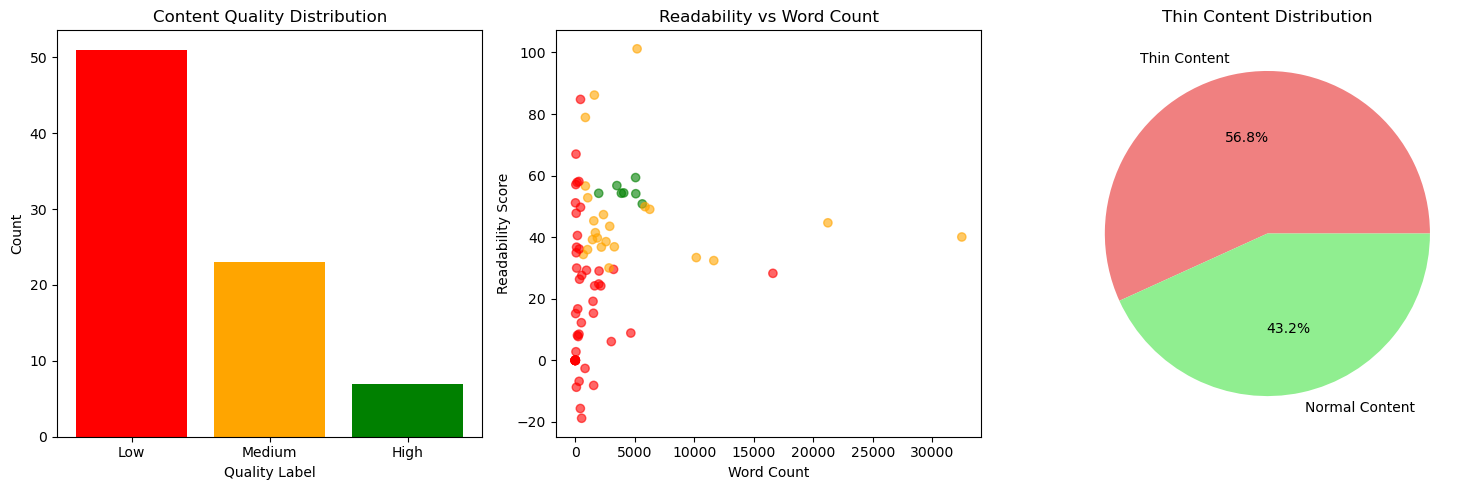

Visualizations created and saved to data/visualizations.png


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the updated features
df = pd.read_csv('../data/features.csv')

# Create visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Quality distribution
plt.subplot(1, 3, 1)
quality_counts = df['quality_label'].value_counts()
colors = ['red', 'orange', 'green']
plt.bar(quality_counts.index, quality_counts.values, color=colors)
plt.title('Content Quality Distribution')
plt.xlabel('Quality Label')
plt.ylabel('Count')

# Plot 2: Readability vs Word Count
plt.subplot(1, 3, 2)
quality_colors = {'Low': 'red', 'Medium': 'orange', 'High': 'green'}
color_map = [quality_colors[label] for label in df['quality_label']]
plt.scatter(df['word_count'], df['flesch_reading_ease'], c=color_map, alpha=0.6)
plt.xlabel('Word Count')
plt.ylabel('Readability Score')
plt.title('Readability vs Word Count')

# Plot 3: Thin content pie chart
plt.subplot(1, 3, 3)
thin_counts = df['is_thin'].value_counts()
labels = ['Thin Content', 'Normal Content']
plt.pie(thin_counts.values, labels=labels, autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Thin Content Distribution')

plt.tight_layout()
plt.savefig('../data/visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations created and saved to data/visualizations.png")